In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [3]:
sys.path.insert(0, "../metapop")

from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


In [4]:
from building2title import selected_buildings, building2title

building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id[5]     = "Rest"

def building2num(building):
    if building in selected_buildings:
        return selected_buildings.index(building)
    else:
        return 5

buildings_ordered_index  = list(np.flip(np.argsort([w.split("-")[1] for w in ward_names])))
ward_names               = [ward_names[i] for i in buildings_ordered_index]

trans_matrix  = M_df.sum(-1)+1
trans_matrix  = trans_matrix[buildings_ordered_index,:][:,buildings_ordered_index]

buildings_all2num = {b: building2num(b) for num, b in enumerate(np.unique([w.split("-")[1] for w  in ward_names]))}


In [5]:

trans_mat_building = np.zeros((len(selected_buildings), len(selected_buildings)))

for iw in range(trans_matrix.shape[0]):
    for jw in range(trans_matrix.shape[1]):
        building_iw = buildings_all2num[ward_names[iw].split("-")[1]]
        building_jw = buildings_all2num[ward_names[jw].split("-")[1]]

        trans_mat_building[building_iw, building_jw] += trans_matrix[iw, jw]


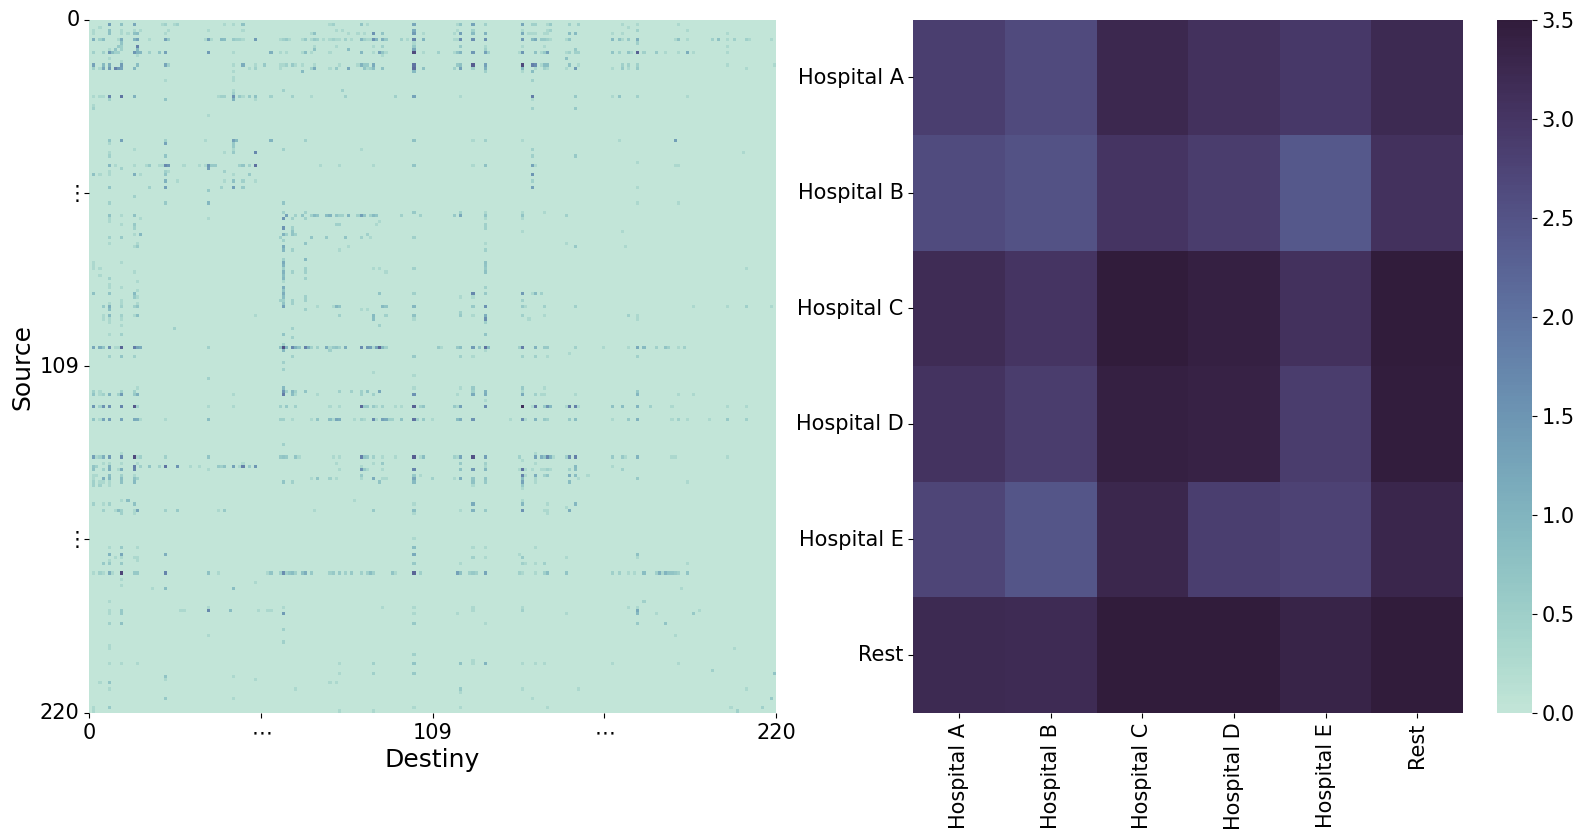

In [6]:
from utils_local import plot_utils
import seaborn as sns
import matplotlib.pyplot as plt


selected_buildings_plot = [building2title[b] for b in selected_buildings]

transfer_ward_df  = pd.DataFrame(np.log10(trans_matrix))
transfer_build_df = pd.DataFrame(np.log10(trans_mat_building), columns=selected_buildings_plot, index=selected_buildings_plot)

fig, ax = plt.subplots(1, 2, figsize=(19.5, 9))

palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True) #sns.color_palette("crest", as_cmap=True)

ax_hm   = sns.heatmap(ax = ax[0], data=transfer_ward_df, cmap=palette,  cbar=False, vmin=0, vmax=3.5)
ax_hm_b = sns.heatmap(ax = ax[1], data=transfer_build_df, cmap=palette,  cbar=True, vmin=0, vmax=3.5)

xticks         = transfer_ward_df.columns
keptxticksidx  = np.linspace(0, len(xticks), 5)
xtickslabels   = list(xticks[ np.maximum(keptxticksidx.astype(int)-1,0) ])
xtickslabels   = ['{:}'.format(l) for l in xtickslabels]

yticks         = transfer_ward_df.index
keptyticksidx  = np.linspace(0,len(yticks), 5)
ytickslabels   = list(yticks[ np.maximum(keptyticksidx.astype(int)-1,0) ])
ytickslabels   = ['{:}'.format(l) for l in ytickslabels]

ytickslabels[1]  = r"$\vdots$"
ytickslabels[-2] = r"$\vdots$"

xtickslabels[1]  = r"$\cdots$"
xtickslabels[-2] = r"$\cdots$"

ax_hm.set_xticks(keptxticksidx)
ax_hm.set_yticks(keptyticksidx)

ax_hm.set_xticklabels(xtickslabels, rotation=0)
ax_hm.set_yticklabels(ytickslabels,)

ax_hm_b.set_yticklabels(selected_buildings_plot, rotation=0)

ax_hm.set_ylabel("Source")
ax_hm.set_xlabel("Destiny")

fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures", "TransferMatrices_figS1.png"),
                                                                                        dpi         = 300,
                                                                                        transparent = True,
                                                                                        bbox_inches = 'tight')


In [11]:
from building2title import selected_buildings, building2title

building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id[5]     = "Rest"

def building2num(building):
    if building in selected_buildings:
        return selected_buildings.index(building)
    else:
        return 5


wards_use_correct_df = pd.read_csv(os.path.join(results2_dir, "paper_figures", "wards_use_corrected.csv"))
ward_names = list(wards_use_correct_df.ward.values)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=len(ward_names), ward_names=ward_names)


buildings_ordered_index  = list(np.flip(np.argsort([w.split("-")[1] for w in ward_names])))
ward_names               = [ward_names[i] for i in buildings_ordered_index]

trans_matrix  = M_df.sum(-1)+1
trans_matrix  = trans_matrix[buildings_ordered_index,:][:,buildings_ordered_index]

buildings_all2num = {b: building2num(b) for num, b in enumerate(np.unique([w.split("-")[1] for w  in ward_names]))}


trans_mat_building = np.zeros((len(selected_buildings), len(selected_buildings)))

for iw in range(trans_matrix.shape[0]):
    for jw in range(trans_matrix.shape[1]):

        building_iw = buildings_all2num[ward_names[iw].split("-")[1]]
        building_jw = buildings_all2num[ward_names[jw].split("-")[1]]

        trans_mat_building[building_iw, building_jw] += trans_matrix[iw, jw]


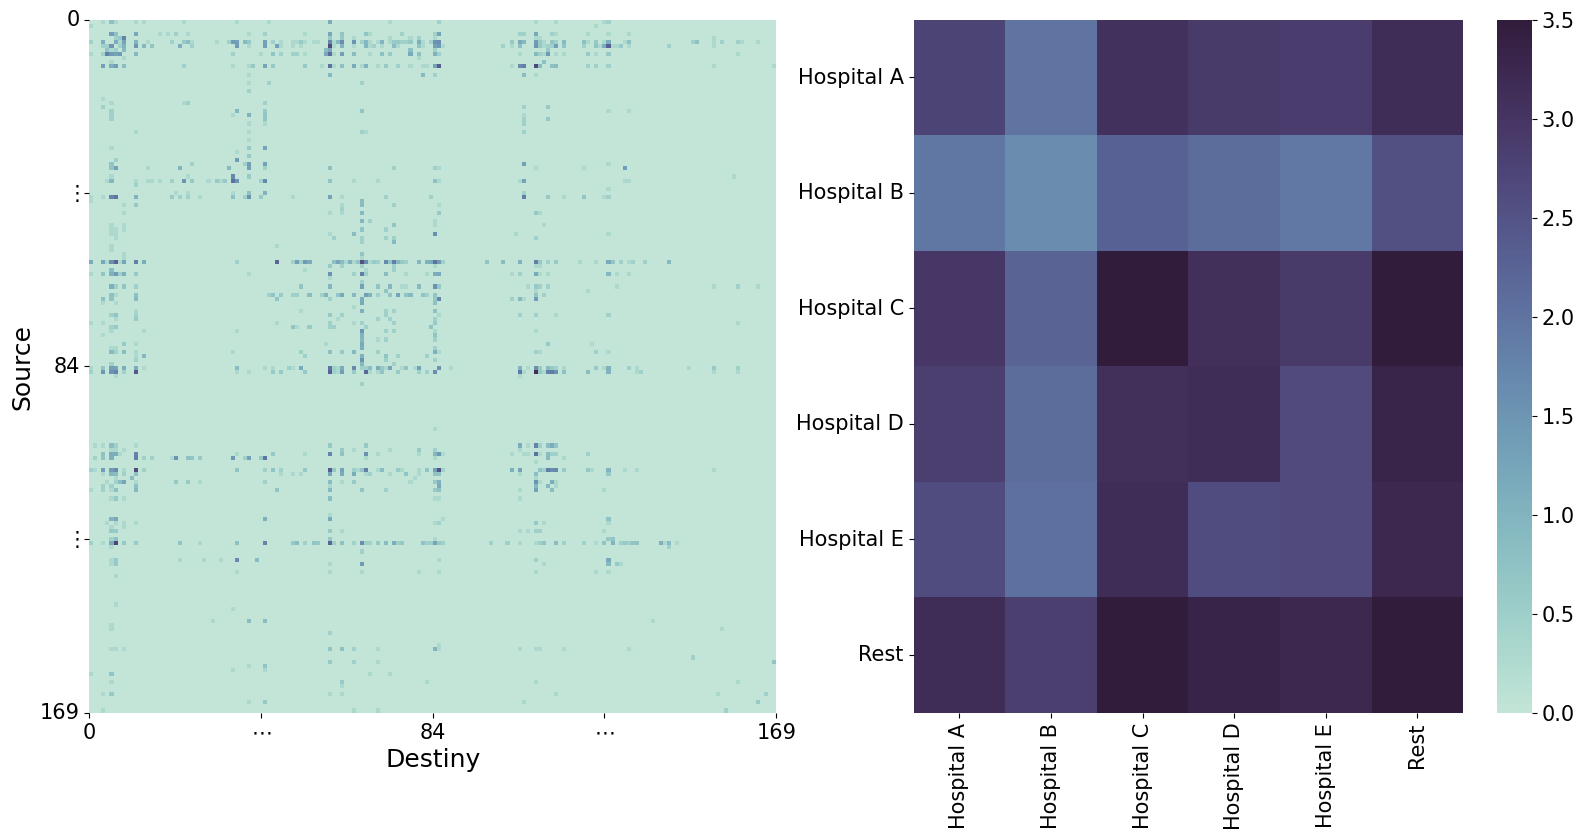

In [12]:
from utils_local import plot_utils
import seaborn as sns
import matplotlib.pyplot as plt


selected_buildings_plot = [building2title[b] for b in selected_buildings]

transfer_ward_df  = pd.DataFrame(np.log10(trans_matrix))
transfer_build_df = pd.DataFrame(np.log10(trans_mat_building), columns=selected_buildings_plot, index=selected_buildings_plot)

fig, ax = plt.subplots(1, 2, figsize=(19.5, 9))

palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True) #sns.color_palette("crest", as_cmap=True)

ax_hm   = sns.heatmap(ax = ax[0], data=transfer_ward_df, cmap=palette,  cbar=False, vmin=0, vmax=3.5)
ax_hm_b = sns.heatmap(ax = ax[1], data=transfer_build_df, cmap=palette,  cbar=True, vmin=0, vmax=3.5)

xticks         = transfer_ward_df.columns
keptxticksidx  = np.linspace(0, len(xticks), 5)
xtickslabels   = list(xticks[ np.maximum(keptxticksidx.astype(int)-1,0) ])
xtickslabels   = ['{:}'.format(l) for l in xtickslabels]

yticks         = transfer_ward_df.index
keptyticksidx  = np.linspace(0,len(yticks), 5)
ytickslabels   = list(yticks[ np.maximum(keptyticksidx.astype(int)-1,0) ])
ytickslabels   = ['{:}'.format(l) for l in ytickslabels]

ytickslabels[1]  = r"$\vdots$"
ytickslabels[-2] = r"$\vdots$"

xtickslabels[1]  = r"$\cdots$"
xtickslabels[-2] = r"$\cdots$"

ax_hm.set_xticks(keptxticksidx)
ax_hm.set_yticks(keptyticksidx)

ax_hm.set_xticklabels(xtickslabels, rotation=0)
ax_hm.set_yticklabels(ytickslabels,)

ax_hm_b.set_yticklabels(selected_buildings_plot, rotation=0)

ax_hm.set_ylabel("Source")
ax_hm.set_xlabel("Destiny")

fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures_corrected", "TransferMatrices_figS1.png"),
                                                                                        dpi         = 300,
                                                                                        transparent = True,
                                                                                        bbox_inches = 'tight')
